In [1]:
import glob
import csv
import os
from tsne import bh_sne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
from numpy.random import RandomState
np.random.seed(1)

In [2]:
bytesdir = "Datasets/Detection/Bytes"

In [3]:
cur_dir = os.getcwd()
os.chdir(bytesdir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_bytes = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.bytes'))  # assuming the bytes are stored as 'bytes'
    no_bytes.append(len1)
    os.chdir('..')
num_samples = np.sum(no_bytes)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_bytes:
    print ("Label:%2d\tFamily: %15s\tNumber of bytes: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
flist = [] # List of bytes paths
print("Processing bytes ...")
for i in range(len(list_fams)):
    for bytes_file in glob.glob(list_fams[i]+'/*.bytes'):
        #print("[%d] Processing bytes: %s" % (cnt, bytes_file))
        flist.append(os.path.join(os.getcwd(),bytes_file))
        cnt += 1
print("bytes processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of bytes: 1986
Label: 1	Family:          WinExe	Number of bytes: 1945
Processing bytes ...
bytes processed: 3931


In [4]:
num_samples = len(flist)
print("Number of samples: %i" %(num_samples))

Number of samples: 3931


In [5]:
flist

['/home/edmar/GIT/Bankers/Datasets/Detection/Bytes/Banker/5244c05cc879d44406d0da0b0cd42517678e2c65cb32415ea2a6fa1e312ebabb.bytes',
 '/home/edmar/GIT/Bankers/Datasets/Detection/Bytes/Banker/ae91186d179f5f745676cab50c1190020b430f494f0deff878b1385c7867fdf6.bytes',
 '/home/edmar/GIT/Bankers/Datasets/Detection/Bytes/Banker/317059906dbb285d30163adfcdc5ad6398c3142abfae5a3f2c6bcd7bd5ff96c4.bytes',
 '/home/edmar/GIT/Bankers/Datasets/Detection/Bytes/Banker/e2cb094f55979ead233dc3499c7df47391f2c452e8c9d4eca772d5a67401ede6.bytes',
 '/home/edmar/GIT/Bankers/Datasets/Detection/Bytes/Banker/448e54b2db7337ed5eb4e2efbd464418c8820626898bb4187fc8d48d5b7f139c.bytes',
 '/home/edmar/GIT/Bankers/Datasets/Detection/Bytes/Banker/878637534eb6dd86d8fbdeb0a174a9d23fa95eb60481f89aaeb6fdb022afeeef.bytes',
 '/home/edmar/GIT/Bankers/Datasets/Detection/Bytes/Banker/183bed1b041601ed1842da92188d7cc573ba57d66dbc958914c21cd8b3c93fbb.bytes',
 '/home/edmar/GIT/Bankers/Datasets/Detection/Bytes/Banker/d450096221277385f70aab8e7

In [6]:
vectorizer = CountVectorizer(input='filename', ngram_range=(2, 2), stop_words=None, token_pattern=r'\w\w\b', min_df=1)

In [7]:
filename = 'bankers-byte2gram.npy'
if os.path.exists(filename):
    print("Loading Byte1gram extracted features from %s ..." %(filename))
    X = np.load(filename)
else:
    print("Extracting Byte2gram features ...")
    X = vectorizer.fit_transform(flist)
    X = X.todense()    
    print("Saving Byte2gram extracted features into %s ..." %(filename))
    np.save(filename, X)

Extracting Byte2gram features ...
Saving Byte2gram extracted features into bankers-byte2gram.npy ...


In [8]:
X

matrix([[ 12426,    233,     62, ...,      5,      5,   4305],
        [ 52177,   1039,    396, ...,     56,    185,  18050],
        [169174,   9618,  17671, ...,     40,    666,  25528],
        ...,
        [  5795,    126,     15, ...,      0,      0,    742],
        [  4718,   1028,     50, ...,      1,      4,   1792],
        [200633,   2771,   1140, ...,    139,    160,  38310]],
       dtype=int64)

In [9]:
if (np.where(np.isnan(X)))[0].shape[0]: 
    print("X contains nan")
else:
    print("X does not contain nan")

X does not contain nan


In [10]:
X.shape

(3931, 65536)

In [11]:
y

array([0., 0., 0., ..., 1., 1., 1.])

In [12]:
y.shape

(3931,)

In [13]:
no_bytes

[1986, 1945]

In [14]:
list_fams

['Banker', 'WinExe']

In [15]:
print("Running t-SNE ...")
vis_data = bh_sne(np.float64(X), d=2, perplexity=30., theta=0.5, random_state=RandomState(1))
#vis_data = TSNE(n_components=2,random_state=1).fit_transform(X)

Running t-SNE ...


Plotting t-SNE ...


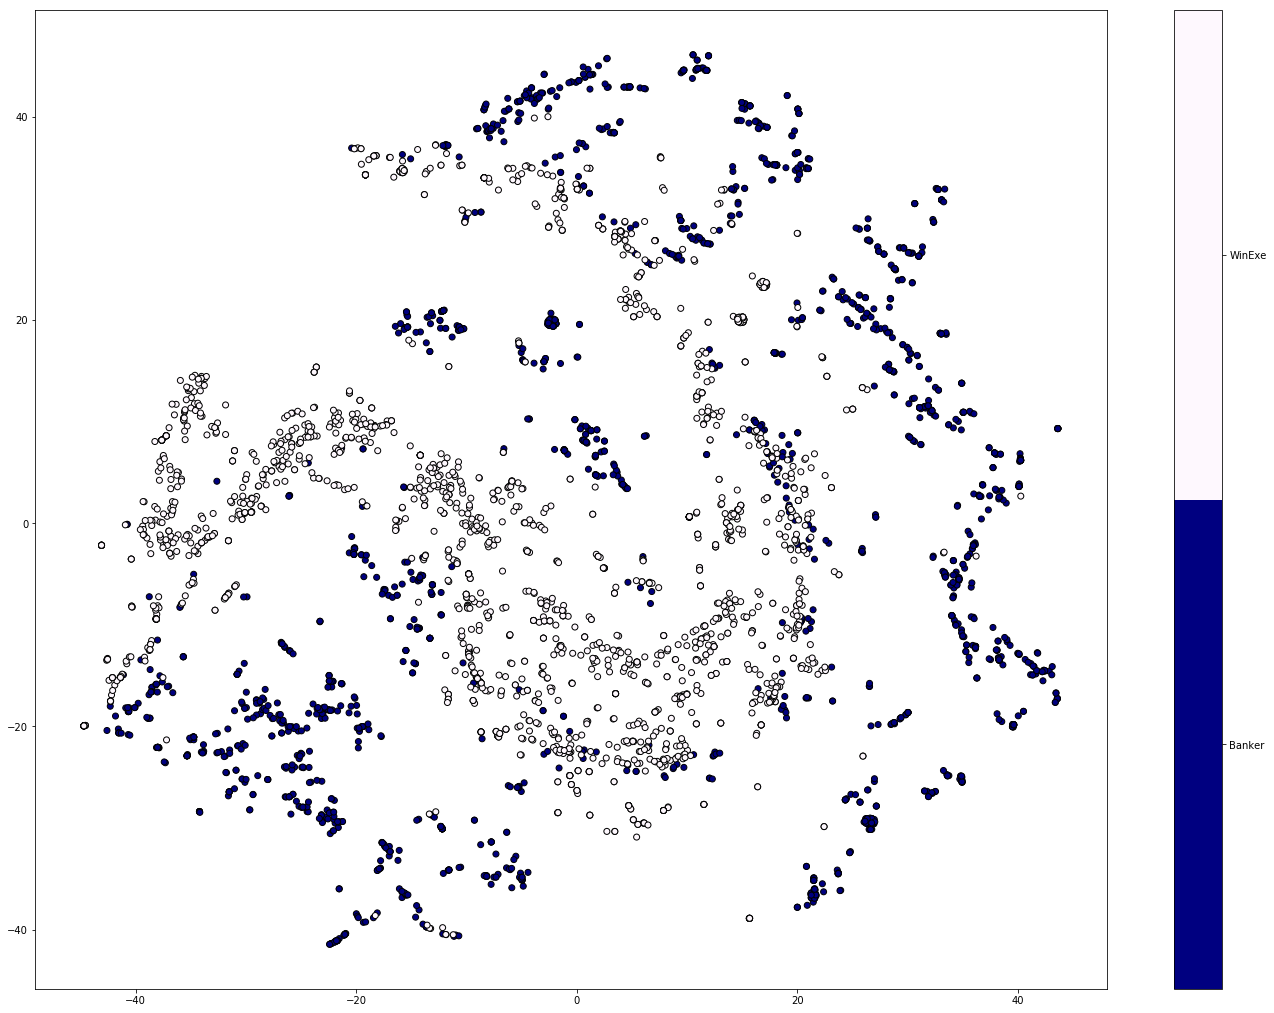

In [16]:
print("Plotting t-SNE ...")
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.scatter(vis_data[:, 0], vis_data[:, 1], c=y, cmap=plt.cm.get_cmap("gist_ncar", len(list_fams)),edgecolors="black")
plt.clim(-0.5, len(list_fams)-0.5)
cbar = plt.colorbar(ticks=range(len(list_fams)))
cbar.ax.set_yticklabels(list_fams)                     
plt.show()

In [17]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [18]:
# Training top_model and saving min training loss weights
n_neighbors = 1
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    top_model = KNeighborsClassifier(n_neighbors, weights='distance',n_jobs=-1)
    top_model.fit(X_train,y_train)  # Training
    y_pred = top_model.predict(X_test)  # Testing
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Test acurracy: 0.9733
[1] Test acurracy: 0.9606
[2] Test acurracy: 0.9580
[3] Test acurracy: 0.9593
[4] Test acurracy: 0.9656


In [19]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9634


Plotting the confusion matrix


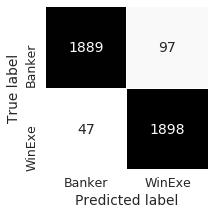

In [20]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


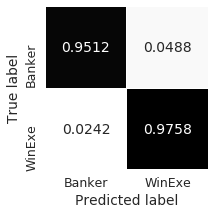

In [21]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()